# Предобучение Transformer Encoder с MLM

Ноутбук реализует предобучение Transformer Encoder с помощью Masked Language Modeling (MLM), а затем использует предобученную модель для классификации AG News.

**Цель**: предобучить трансформер на задаче MLM, затем использовать для классификации.

**Датасет**: AG News (для предобучения используем train набор без лейблов, для классификации - train/val/test с лейблами)

**Модель MLM**: Embedding(256) + Positional Encoding → Transformer Encoder → MLM Head → Linear(256, vocab_size)

**Модель классификации**: Предобученный Encoder → CLS токен → Dropout(0.3) → Linear(256, 4)


## Шаг 1: Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.2
CUDA available: True


## Шаг 2: Загрузка датасета и создание словаря

Используем ту же токенизацию и словарь что и в первом ноутбуке с трансформером.


In [2]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
CLS_TOKEN = '<cls>'
MASK_TOKEN = '<mask>'
PAD_IDX = 0
UNK_IDX = 1
CLS_IDX = 2
MASK_IDX = 3

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

print("Building vocabulary...")
word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX, CLS_TOKEN: CLS_IDX, MASK_TOKEN: MASK_IDX}
vocab_size = 4

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words: {list(vocab.keys())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}


Loading AG News dataset...
Building vocabulary...

Vocabulary size: 30000
Top 10 words: ['<pad>', '<unk>', '<cls>', '<mask>', 'the', 'to', 'a', 'of', 'in', 'and']


## Шаг 3: Позиционное кодирование

Используем ту же реализацию позиционного кодирования что и в первом ноутбуке.


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


## Шаг 4: Transformer Encoder для MLM

Создаём модель трансформера с MLM head для предобучения.


In [4]:
class TransformerEncoderMLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.3, max_len=128):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.mlm_head = nn.Linear(d_model, vocab_size)
        
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
    
    def forward(self, x, mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        src_key_padding_mask = ~mask
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        mlm_logits = self.mlm_head(x)
        return mlm_logits
    
    def get_encoder(self):
        return self.transformer_encoder, self.embedding, self.pos_encoder


## Шаг 5: Dataset для MLM

Создаём dataset который маскирует 15% токенов для задачи MLM. Из маскированных токенов: 80% заменяем на MASK, 10% на случайный токен, 10% оставляем как есть.


In [5]:
class MLMDataset(Dataset):
    def __init__(self, texts, vocab, max_len=128, mask_prob=0.15):
        self.texts = texts
        self.vocab = vocab
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.vocab_list = list(vocab.keys())
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = simple_tokenize(text)
        indices = [CLS_IDX] + [self.vocab.get(token, UNK_IDX) for token in tokens]
        
        if len(indices) > self.max_len - 1:
            indices = indices[:self.max_len - 1]
        
        input_ids = torch.tensor(indices, dtype=torch.long)
        labels = input_ids.clone()
        mask = torch.ones(len(input_ids), dtype=torch.bool)
        
        num_to_mask = max(1, int(len(input_ids) * self.mask_prob))
        mask_positions = random.sample(range(1, len(input_ids)), min(num_to_mask, len(input_ids) - 1))
        
        for pos in mask_positions:
            rand = random.random()
            if rand < 0.8:
                input_ids[pos] = MASK_IDX
            elif rand < 0.9:
                input_ids[pos] = random.randint(4, len(self.vocab) - 1)
        
        return input_ids, labels, mask

def collate_fn_mlm(batch):
    input_ids_list, labels_list, masks_list = zip(*batch)
    max_len = max(len(ids) for ids in input_ids_list)
    
    padded_input_ids = []
    padded_labels = []
    padded_masks = []
    
    for input_ids, labels, mask in zip(input_ids_list, labels_list, masks_list):
        pad_length = max_len - len(input_ids)
        padded_input = torch.cat([input_ids, torch.full((pad_length,), PAD_IDX, dtype=torch.long)])
        padded_label = torch.cat([labels, torch.full((pad_length,), PAD_IDX, dtype=torch.long)])
        padded_mask_bool = torch.cat([mask, torch.zeros(pad_length, dtype=torch.bool)])
        
        padded_input_ids.append(padded_input)
        padded_labels.append(padded_label)
        padded_masks.append(padded_mask_bool)
    
    return torch.stack(padded_input_ids), torch.stack(padded_labels), torch.stack(padded_masks)

max_len = 128
mlm_train_dataset = MLMDataset(train_texts, vocab, max_len=max_len)
mlm_val_dataset = MLMDataset(val_texts[:1000], vocab, max_len=max_len)

print(f"MLM Train dataset size: {len(mlm_train_dataset)}")
print(f"MLM Val dataset size: {len(mlm_val_dataset)}")

sample_input, sample_labels, sample_mask = mlm_train_dataset[0]
print(f"\nSample MLM:")
print(f"  Input length: {len(sample_input)}")
print(f"  Input IDs: {sample_input[:20].tolist()}")
print(f"  Labels: {sample_labels[:20].tolist()}")
print(f"  Masked positions: {torch.where(sample_input == MASK_IDX)[0].tolist()}")


MLM Train dataset size: 108000
MLM Val dataset size: 1000

Sample MLM:
  Input length: 54
  Input IDs: [2, 138, 2852, 14, 676, 2624, 379, 1837, 3, 3, 86, 863, 5, 1688, 6, 3, 3, 6, 3, 231]
  Labels: [2, 138, 1790, 14, 676, 2624, 379, 1837, 1790, 3695, 86, 863, 5, 1688, 6, 7543, 5331, 6, 5772, 231]
  Masked positions: [8, 9, 15, 16, 18, 41, 48]


In [6]:
class MLMModule(pl.LightningModule):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.3, max_len=128, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = TransformerEncoderMLM(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, max_len)
        self.lr = lr
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    def forward(self, x, mask):
        return self.model(x, mask)
    
    def training_step(self, batch, batch_idx):
        input_ids, labels, mask = batch
        logits = self(input_ids, mask)
        
        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1)
        
        loss = self.criterion(logits, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, labels, mask = batch
        logits = self(input_ids, mask)
        
        logits = logits.view(-1, logits.size(-1))
        labels = labels.view(-1)
        
        loss = self.criterion(logits, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-8)
        return optimizer


## Шаг 7: Предобучение на MLM

Обучаем трансформер на задаче MLM в течение 2 эпох.


In [7]:
batch_size = 128
mlm_train_loader = DataLoader(mlm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_mlm)
mlm_val_loader = DataLoader(mlm_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_mlm)

vocab_size = len(vocab)
mlm_model = MLMModule(
    vocab_size=vocab_size,
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    dropout=0.3,
    max_len=max_len,
    lr=1e-4
)

trainer_mlm = pl.Trainer(
    max_epochs=2,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=100,
    gradient_clip_val=1.0
)

print("Starting MLM pretraining...")
start_time = time.time()
trainer_mlm.fit(mlm_model, mlm_train_loader, mlm_val_loader)
mlm_time = time.time() - start_time

print(f"\nMLM pretraining completed in {mlm_time:.2f} seconds")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Starting MLM pretraining...



  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | TransformerEncoderMLM | 20.1 M | train
1 | criterion | CrossEntropyLoss      | 0      | train
------------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.514    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.



MLM pretraining completed in 240.86 seconds


## Шаг 8: Модель классификатора с предобученным encoder

Создаём модель классификатора используя предобученный encoder из MLM модели.


In [8]:
class TransformerEncoderClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.3, num_classes=4, max_len=128, pretrained_encoder=None):
        super().__init__()
        self.d_model = d_model
        
        if pretrained_encoder is not None:
            self.embedding = pretrained_encoder.embedding
            self.pos_encoder = pretrained_encoder.pos_encoder
            self.transformer_encoder = pretrained_encoder.transformer_encoder
        else:
            self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
            self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
            
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True,
                activation='gelu'
            )
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
    
    def forward(self, x, mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        src_key_padding_mask = ~mask
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        cls_token = x[:, 0, :]
        x = self.dropout(cls_token)
        x = self.fc(x)
        return x

pretrained_classifier = TransformerEncoderClassifier(
    vocab_size=vocab_size,
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    dropout=0.3,
    num_classes=4,
    max_len=max_len,
    pretrained_encoder=mlm_model.model
)

print("Classifier model created with pretrained encoder")


Classifier model created with pretrained encoder


## Шаг 9: Dataset для классификации

Создаём dataset для задачи классификации используя тот же формат что и в первом ноутбуке.


In [9]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = simple_tokenize(text)
        indices = [CLS_IDX] + [self.vocab.get(token, UNK_IDX) for token in tokens]
        
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    max_len = max(lengths)
    
    padded_texts = []
    masks = []
    for text in texts:
        pad_length = max_len - len(text)
        padded = torch.cat([text, torch.full((pad_length,), PAD_IDX, dtype=torch.long)])
        mask = torch.cat([torch.ones(len(text), dtype=torch.bool), torch.zeros(pad_length, dtype=torch.bool)])
        padded_texts.append(padded)
        masks.append(mask)
    
    return torch.stack(padded_texts), torch.stack(masks), torch.stack(labels)

train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600


## Шаг 10: Lightning модуль для классификации

PyTorch Lightning модуль для обучения классификатора с предобученным encoder.


In [15]:
class TransformerModule(pl.LightningModule):
    def __init__(self, model, num_classes=4, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.lr = lr
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, mask):
        return self.model(x, mask)
    
    def training_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, mask, y = batch
        logits = self(x, mask)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-8)
        return optimizer


## Шаг 11: Обучение классификатора

Обучаем классификатор с предобученным encoder в течение 3 эпох.


In [16]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

classifier_model = TransformerModule(pretrained_classifier, num_classes=4, lr=1e-5)

trainer_classifier = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50,
    gradient_clip_val=1.0
)

print("Starting classifier training with pretrained encoder...")
start_time = time.time()
trainer_classifier.fit(classifier_model, train_loader, val_loader)
classifier_time = time.time() - start_time

print(f"\nClassifier training completed in {classifier_time:.2f} seconds")


/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                         | Params | Mode 
-------------------------------------------------------------------
0 | model     | TransformerEncoderClassifier | 12.4 M | eval 
1 | train_acc | MulticlassAccuracy           | 0      | train
2 | val_acc   | MulticlassAccuracy           | 0      | train
3 | val_f1    | MulticlassF1Score    

Starting classifier training with pretrained encoder...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.



Classifier training completed in 168.68 seconds


## Шаг 12: Оценка на тесте

Оцениваем на test наборе: accuracy и macro F1 score.


In [17]:
from tqdm.notebook import tqdm

test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

classifier_model.eval()
device = next(classifier_model.parameters()).device
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, mask, y = batch
        x = x.to(device)
        mask = mask.to(device)
        y = y.to(device)
        
        logits = classifier_model(x, mask)
        preds = torch.argmax(logits, dim=1)
        
        test_acc(logits, y)
        test_f1(logits, y)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

pretrained_test_acc = test_acc.compute().item()
pretrained_test_f1 = test_f1.compute().item()

print(f"Test Accuracy: {pretrained_test_acc:.4f}")
print(f"Test Macro F1: {pretrained_test_f1:.4f}")


  0%|          | 0/60 [00:00<?, ?it/s]

Test Accuracy: 0.9116
Test Macro F1: 0.9115


## Шаг 13: Confusion Matrix

Визуализируем confusion matrix на test наборе.


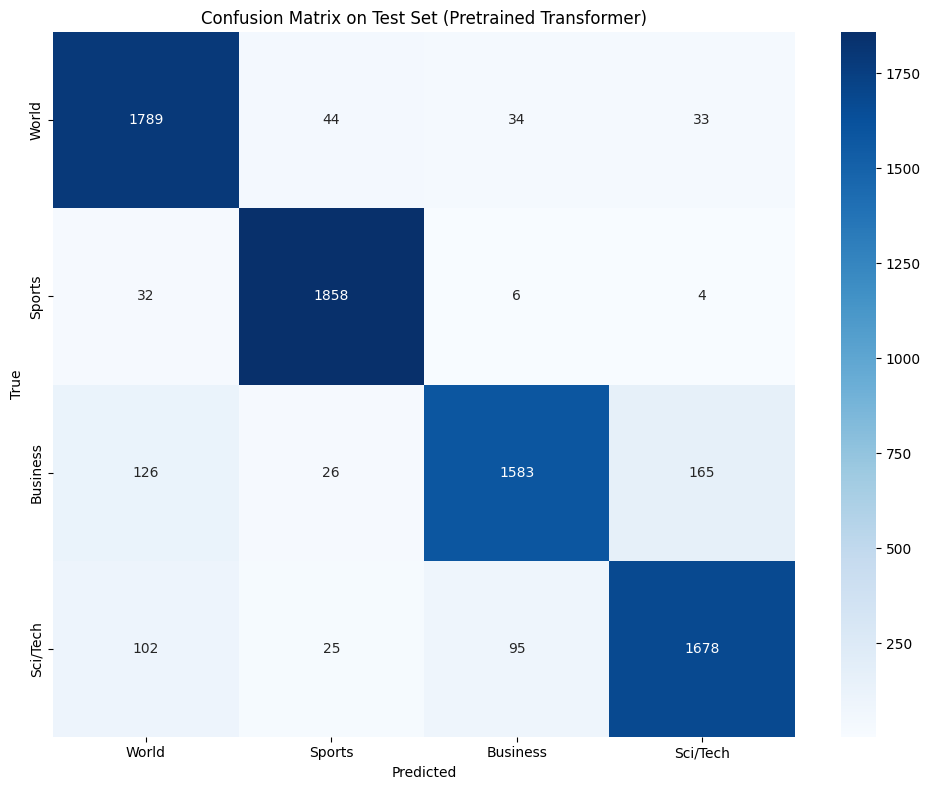

World: Precision=0.873, Recall=0.942, F1=0.906
Sports: Precision=0.951, Recall=0.978, F1=0.964
Business: Precision=0.921, Recall=0.833, F1=0.875
Sci/Tech: Precision=0.893, Recall=0.883, F1=0.888


In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (Pretrained Transformer)')
plt.tight_layout()
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


## Шаг 14: Анализ ошибок

Находим и показываем 5 типичных ошибок (текст, истинный лейбл, предсказанный лейбл).


In [14]:
errors = []
for i, (true_label, pred_label) in enumerate(zip(all_labels, all_preds)):
    if true_label != pred_label:
        errors.append((i, true_label, pred_label))

print(f"Total errors: {len(errors)} out of {len(all_labels)} ({len(errors)/len(all_labels)*100:.2f}%)")
print("\n5 Typical Errors:\n")

for idx, (i, true_label, pred_label) in enumerate(errors[:5]):
    text = test_texts[i]
    print(f"Error {idx+1}:")
    print(f"  True: {class_names[true_label]} ({true_label})")
    print(f"  Pred: {class_names[pred_label]} ({pred_label})")
    print(f"  Text: {text[:200]}...")
    print()


Total errors: 692 out of 7600 (9.11%)

5 Typical Errors:

Error 1:
  True: Sci/Tech (3)
  Pred: Sports (1)
  Text: Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m....

Error 2:
  True: Sci/Tech (3)
  Pred: World (0)
  Text: Socialites unite dolphin groups Dolphin groups, or "pods", rely on socialites to keep them from collapsing, scientists claim....

Error 3:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: Rivals Try to Turn Tables on Charles Schwab By MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an ...

Error 4:
  True: Sci/Tech (3)
  Pred: Sports (1)
  Text: Promoting a Shared Vision As Michael Kaleko kept running into people who were getting older and having more vision problems, he realized he could do something about it....

Error 5:
  True: World (0)
